# Imports

In [42]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

# Functions

In [43]:
def copy_images(src_root, dst_root, image_extensions=('jpg', 'jpeg', 'png', 'gif', 'bmp', 'tiff')):
    """
    Copy all images from all subdirectories of src_root to dst_root.

    :param src_root: Source root directory
    :param dst_root: Destination root directory
    :param image_extensions: Tuple of image file extensions to look for
    """
    if not os.path.exists(dst_root):
        os.makedirs(dst_root)
    
    for subdir, dirs, files in os.walk(src_root):
        for file in files:
            if file.lower().endswith(image_extensions):
                src_file_path = os.path.join(subdir, file)
                dst_file_path = os.path.join(dst_root, file)
                shutil.copy2(src_file_path, dst_file_path)
                print(f"Copied: {src_file_path} to {dst_file_path}")

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, labels, xlabel, ylabel, percent=False, save_path=None):
    try:
        cm = confusion_matrix(y_true, y_pred, labels=labels)
    
        if percent:
            
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            fmt = ".2%"
        else:
            fmt = "d"
            
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt=fmt, cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.xlabel(xlabel, fontsize=14)
        plt.ylabel(ylabel, fontsize=14)
        plt.title(title, fontsize=16)
        
        if save_path:
            plt.savefig(save_path)
        plt.close()   
       # plt.show()
    except ValueError:
        pass

# Function to calculate and print classification metrics
def classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
    recall = recall_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
    f1 = f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
    
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }
    return metrics

# Function to preprocess and extract features based on modality
def extract_features(df, feature_to_evaluate, reader_1, reader_2, modality=None, projection_substring=None):
    feature_column_r1 = feature_to_evaluate + '_' + reader_1
    feature_column_r2 = feature_to_evaluate + '_' + reader_2
    
    df_filtered = df
    if modality:
        df_filtered = df_filtered.loc[df_filtered['Modality'].str.contains(modality, na=False)]
    if projection_substring:
        df_filtered = df_filtered.loc[df_filtered['Projection'].str.contains(projection_substring, na=False)]
    
    df_combined = df_filtered[[feature_column_r1, feature_column_r2]].dropna()
    
    feature_r1 = df_combined[feature_column_r1].astype(str)
    feature_r2 = df_combined[feature_column_r2].astype(str)
    
    return feature_r1, feature_r2

# Function to handle plotting and metrics
def process_and_plot(df, feature_to_evaluate, reader_1, reader_2, reader_1_name, reader_2_name, labels, title_prefix, modality=None, projection_substring=None):
    feature_r1, feature_r2 = extract_features(df, feature_to_evaluate, reader_1, reader_2, modality, projection_substring)

    title = f"{title_prefix}: {feature_to_evaluate} between {reader_1_name} and {reader_2_name}"
    plot_confusion_matrix(feature_r1, feature_r2, title, labels, reader_2_name, reader_1_name, save_path=f'plots/{reader_1_name} vs {reader_2_name} {feature_to_evaluate} {title_prefix}.png')

    title_percent = f"{title_prefix}: {feature_to_evaluate} between {reader_1_name} and {reader_2_name} (%)"
    plot_confusion_matrix(feature_r1, feature_r2, title_percent, labels, reader_2_name, reader_1_name, percent=True, save_path=f'plots/{reader_1_name} vs {reader_2_name} {feature_to_evaluate} {title_prefix} Percent.png')
   
    
    metrics = classification_metrics(feature_r1, feature_r2)
    return metrics

    
# Function to read a CSV file and display its contents
def read_csv_file(file_path):
    try:
        # Load the CSV file into a DataFrame
        df = pd.read_csv(file_path, sep=";")

        
        # Return the DataFrame for further use if needed
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
       
        
# Function to copy images
def copy_images(df, image_dir, target_dir):
    for sop in df['SOP Instance UID'].tolist():
        shutil.copy(os.path.join(image_dir, sop + '.png'), os.path.join(target_dir, sop + '.png'))


# Function to handle CSV creation and appending
def create_and_append_csv(df, feature_to_evaluate, reader_1, reader_2, test_data_dir_feature):
    feature_reader1 = feature_to_evaluate + "_" + reader_1
    feature_reader2 = feature_to_evaluate + "_" + reader_2

    # Select the relevant columns and rename them
    df_selected = df[['SOP Instance UID', feature_reader1, feature_reader2, 'Projection']]

    # Debug: Check for NaN values before dropping
    print(f"Before dropping NaN values - Selected DataFrame head: {df_selected.head()}")

    # Remove rows with NaN values in the specified columns
    df_selected = df_selected.dropna(subset=[feature_reader1, feature_reader2, 'Projection'])

    # Debug: Check for NaN values after dropping
    print(f"After dropping NaN values - Selected DataFrame head: {df_selected.head()}")

    df_selected.rename(columns={feature_reader1: 'Mamilla Profile Cordoba', feature_reader2: 'Mamilla Profile b-box'}, inplace=True)

    # Define the output CSV path
    output_csv_path = os.path.join(test_data_dir_feature, feature_to_evaluate + '.csv')

    # Append or create CSV
    if os.path.exists(output_csv_path):
        df_existing = pd.read_csv(output_csv_path)
        df_combined = pd.concat([df_existing, df_selected], ignore_index=True).drop_duplicates(subset='SOP Instance UID')
        df_combined.to_csv(output_csv_path, index=False)
    else:
        df_selected.to_csv(output_csv_path, index=False)
    
    return output_csv_path

# Read Files

In [56]:
# raya = '/Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/2024_07_17/all/bbox_data_raya_all.csv'
# romero = '/Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/2024_07_17/all/bbox_data_romero_all.csv'
bbox = '/Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/csv/all/bbox_data_bbox_all.csv'

raya_only_annotated = '/Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/csv/confirmed/bbox_data_RAYA_confirmed_quality.csv'
romero_only_annotated = r'/Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/csv/confirmed/bbox_data ROMERO confimred quality.csv'

# df_raya = read_csv_file(raya)
# df_romero = read_csv_file(romero)
df_bbox = read_csv_file(bbox)
df_raya = read_csv_file(raya_only_annotated)
df_romero = read_csv_file(romero_only_annotated)

# Clean Files

- remove columns that are not necessary
- filter all SOP UID of the same day in bbox file
- Add missing rows to raya / romero dataframe (confirmed)

In [46]:
# Columns to be removed
columns_to_drop = [
    'Patient Name', 
    'Birth Date', 
    'Patient ID', 
    'Operator', 
    'Study Instance UID', 
    'Device', 
    'Diagnostic/Screening', 
    'Capture', 
    'Dose [mGy]',
    'Post-Operative',
    'Unnamed: 43'
    ]

# Drop the specified columns
df_bbox = df_bbox.drop(columns=columns_to_drop)
df_raya = df_raya.drop(columns=columns_to_drop)
df_romero = df_romero.drop(columns=columns_to_drop)


In [27]:
# # Find all study dates
# study_dates_annotated_raya = df_raya.get('Study Date').tolist()
# study_dates_annotated_raya = set([x[0:10] for x in study_dates_annotated_raya])

# study_dates_annotated_romero = df_romero.get('Study Date').tolist()
# study_dates_annotated_romero = set([x[0:10] for x in study_dates_annotated_romero])

# mask_raya = df_bbox['Study Date'].str[:10].isin(study_dates_annotated_raya)
# mask_romero = df_bbox['Study Date'].str[:10].isin(study_dates_annotated_romero)

# # Filter the DataFrame using the mask
# df_bbox_filtered_raya = df_bbox[mask_raya]
# df_bbox_filtered_romero = df_bbox[mask_romero]

In [47]:
# after oral confirmation with Dr. Raya, these are the actual dates to take into account

dates_to_include_raya = ['2024-06-21', '2024-06-25', '2024-06-27','2024-07-08']
dates_to_include_romero = ['2024-06-24', '2024-06-28']

mask_raya = df_bbox['Study Date'].str[:10].isin(dates_to_include_raya)
mask_romero = df_bbox['Study Date'].str[:10].isin(dates_to_include_romero)

# Filter the DataFrame using the mask
df_bbox_filtered_raya = df_bbox[mask_raya]
df_bbox_filtered_romero = df_bbox[mask_romero]

In [48]:
print("Number of files in b-box plus for annotating days of Dr. Raya: ", len(df_bbox_filtered_raya))
print("Number of files reannotated by Dr. Raya: ", len(df_raya))
print("Incorrect quality evaluation of b-box plus (%): ", len(df_raya)/len(df_bbox_filtered_raya)*100 )
print("Number of files in b-box plus for annotating days of Dr. Romero: ", len(df_bbox_filtered_romero))
print("Number of files reannotated by Dr. Romero: ", len(df_romero))
print("Incorrect quality evaluation of b-box plus (%): ", len(df_romero)/len(df_bbox_filtered_romero)*100 )

Number of files in b-box plus for annotating days of Dr. Raya:  513
Number of files reannotated by Dr. Raya:  344
Incorrect quality evaluation of b-box plus (%):  67.05653021442495
Number of files in b-box plus for annotating days of Dr. Romero:  213
Number of files reannotated by Dr. Romero:  120
Incorrect quality evaluation of b-box plus (%):  56.33802816901409


In [49]:
df_bbox.keys()

Index(['Study Date', 'Projection', 'Modality', 'SOP Instance UID',
       'b-quality Created By', 'b-quality Confirmed by Expert',
       'Breast Density', 'b-density Created By',
       'b-density Confirmed by Expert', 'Image Quality', 'Quality Explanation',
       'Quality Performance Score from 0 (Inadequate) to 100 (Perfect)',
       'Compression [N]', 'Compression', 'Symmetry', 'Breast Elevation (MLO)',
       'PNL Difference', 'Pectoralis-Nipple Length [mm]', 'Mamilla Profile',
       'Mamilla Deviation', 'Mamilla Deviation in Degree',
       'Relative Mamilla Coordinates (X, Y)', 'Medial Parenchyma (CC)',
       'Lateral Parenchyma (CC)', 'Parenchyma (MLO)', 'Pectoralis (CC)',
       'Pectoralis Angle', 'Pectoralis Angle in Degree',
       'Pectoralis Nipple Level', 'Pectoralis Relaxation', 'Inframammary Fold',
       'Relative IMF Coordinates (X, Y)', 'Skin Fold most severe finding'],
      dtype='object')

In [8]:
# Identify rows in df_bbox_filtered_raya that are not in df_raya based on 'SOP Instance UID'
missing_rows_raya = df_bbox_filtered_raya[~df_bbox_filtered_raya['SOP Instance UID'].isin(df_raya['SOP Instance UID'])]
# Identify rows in df_bbox_filtered_raya that are not in df_romero based on 'SOP Instance UID'
missing_rows_romero = df_bbox_filtered_romero[~df_bbox_filtered_romero['SOP Instance UID'].isin(df_romero['SOP Instance UID'])]

# Append missing rows to df_raya
df_raya_updated = pd.concat([df_raya, missing_rows_raya], ignore_index=True)
df_romero_updated = pd.concat([df_romero, missing_rows_romero], ignore_index=True)

# Display the updated DataFrame
print(len(df_raya_updated))
print(len(df_romero_updated))

589
237


# Merge Dataframes

- create merged dfs for Dr. Raya and bbox and Dr. Romero and bbox
- clean and save dataframes

In [9]:
# Merge df_raya and df_bbox
merged_raya_bbox = pd.merge(df_raya_updated, df_bbox_filtered_raya, on='SOP Instance UID', suffixes=('_raya', '_bbox'))
merged_raya_bbox = merged_raya_bbox.rename(columns={'Mamilla Profile': 'Mamilla Profile_bbox'})

# Merge df_raya and df_bbox
merged_romero_bbox = pd.merge(df_romero_updated, df_bbox_filtered_romero, on='SOP Instance UID', suffixes=('_romero', '_bbox'))
merged_romero_bbox = merged_romero_bbox.rename(columns={'Mamilla Profile': 'Mamilla Profile_bbox'})

In [10]:
# Columns to be removed
columns_to_drop = [
    'Study Date_bbox',
    'Projection_bbox', 
    'Modality_bbox'
    ]

# Drop the specified columns
merged_raya_bbox = merged_raya_bbox.drop(columns=columns_to_drop)
merged_romero_bbox = merged_romero_bbox.drop(columns=columns_to_drop)
# Rename multiple columns in place
merged_raya_bbox.rename(columns={'Study Date_raya': 'Study_Date', 'Projection_raya': 'Projection', 'Modality_raya': 'Modality'}, inplace=True)
merged_romero_bbox.rename(columns={'Study Date_romero': 'Study_Date', 'Projection_romero': 'Projection', 'Modality_romero': 'Modality'}, inplace=True)

# Save the DataFrame to a CSV file
merged_raya_bbox.to_csv('evaluation/merged_csv_raya_bbox.csv', index=False)
merged_romero_bbox.to_csv('evaluation/merged_csv_romero_bbox.csv', index=False)

# Karol and Alice
**you can start from here and simply load the merged csvs**

In [ ]:
merged_raya_bbox = read_csv_file("path_to_merged_raya")
merged_romero_bbox = read_csv_file("path_to_merged_romero")

# Plot Annotation Days and Numbers

513


<Figure size 1200x600 with 0 Axes>

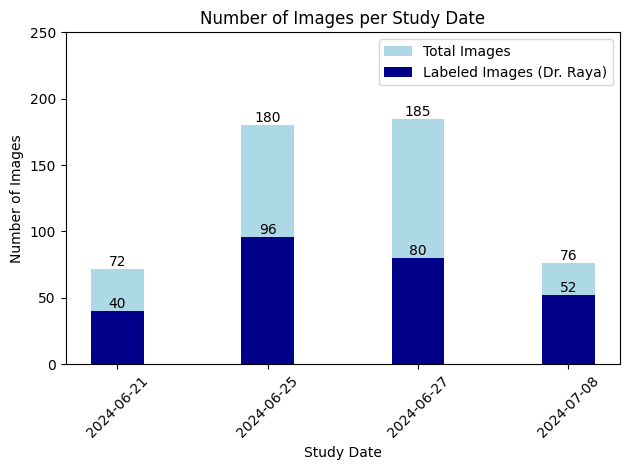

In [18]:
# Create a count of matching entries for each study date
study_date_counts = df_raya['Study Date'].str[:10].value_counts().reindex(dates_to_include_raya, fill_value=0)

# Create a count of matching entries for each study date
study_date_counts_total = df_bbox['Study Date'].str[:10].value_counts().reindex(dates_to_include_raya, fill_value=0)
print(study_date_counts_total.sum())
# Sort by date
study_date_counts = study_date_counts.sort_index()
study_date_counts_total = study_date_counts_total.sort_index()

# Plot the counts
plt.figure(figsize=(12, 6))
width = 0.35  # the width of the bars
ind = range(len(study_date_counts))  # the x locations for the groups


fig, ax = plt.subplots()
bar1 = ax.bar(ind, study_date_counts_total, width, label='Total Images', color='lightblue')
# Overlay labeled counts on top
bar2 = ax.bar(ind, study_date_counts, width, label='Labeled Images (Dr. Raya)', color='darkblue')


# Add labels, title, and legend
ax.set_xlabel('Study Date')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Study Date')
ax.set_xticks(range(len(study_date_counts.index)))
ax.set_xticklabels(study_date_counts.index, rotation=45)
ax.legend()

# Set y-axis limit
ax.set_ylim(0, 250)

# Add the number of entries on top of each bar for study_date_counts
ax.bar_label(bar1, label_type='edge')
ax.bar_label(bar2, label_type='edge')

plt.tight_layout()
plt.savefig(f'plots/number_of_labels_per_study_date_raya.png')
plt.show()

213


<Figure size 1200x600 with 0 Axes>

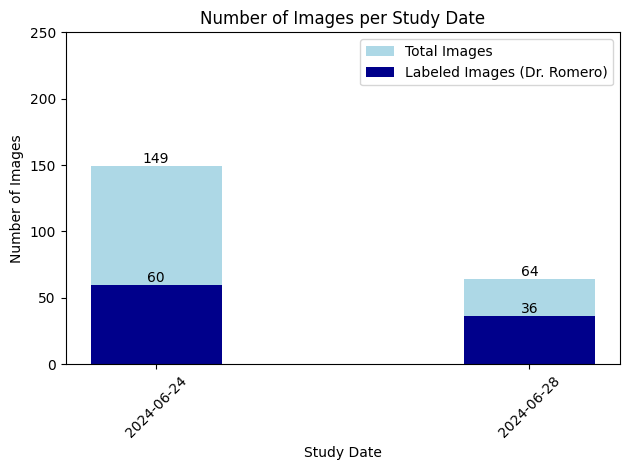

In [17]:
# Create a count of matching entries for each study date
study_date_counts = df_romero['Study Date'].str[:10].value_counts().reindex(dates_to_include_romero, fill_value=0)

# Create a count of matching entries for each study date
study_date_counts_total = df_bbox['Study Date'].str[:10].value_counts().reindex(dates_to_include_romero, fill_value=0)
print(study_date_counts_total.sum())
# Sort by date
study_date_counts = study_date_counts.sort_index()
study_date_counts_total = study_date_counts_total.sort_index()

# Plot the counts
plt.figure(figsize=(12, 6))
width = 0.35  # the width of the bars
ind = range(len(study_date_counts))  # the x locations for the groups

fig, ax = plt.subplots()
bar1 = ax.bar(ind, study_date_counts_total, width, label='Total Images', color='lightblue')
# Overlay labeled counts on to
bar2 = ax.bar(ind, study_date_counts, width, label='Labeled Images (Dr. Romero)', color='darkblue')

# Add labels, title, and legend
ax.set_xlabel('Study Date')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Study Date')
ax.set_xticks(range(len(study_date_counts.index)))
ax.set_xticklabels(study_date_counts.index, rotation=45)
ax.legend()

# Set y-axis limit
ax.set_ylim(0, 250)

# Add the number of entries on top of each bar for study_date_counts
ax.bar_label(bar1, label_type='edge')
ax.bar_label(bar2, label_type='edge')

plt.tight_layout()
plt.savefig(f'plots/number_of_labels_per_study_date_romero.png')
plt.show()


# 

# Evaluation

In [20]:
# Variables
features_to_evaluate = ['Image Quality',
                        'Symmetry', 
                        'Breast Elevation (MLO)', 
                        'PNL Difference', 
                        'Mamilla Profile', 
                        'Mamilla Deviation', 
                        'Medial Parenchyma (CC)', 
                        'Lateral Parenchyma (CC)', 
                        'Parenchyma (MLO)', 
                        'Pectoralis (CC)', 
                        'Pectoralis Angle', 
                        'Pectoralis Nipple Level',
                        'Pectoralis Relaxation',
                        'Inframammary Fold'
                        ]

labels_features = [
    ['perfect', 'good', 'moderate', 'insufficient'],
    ['correct', 'moderate', 'insufficient'],
    ['low', 'correct', 'high'],
    ['correct', 'insufficient'],
    ['correct', 'insufficient'], 
    ['correct', 'insufficient'],
    ['correct', 'insufficient'],
    ['correct', 'insufficient'],
    ['correct', 'insufficient'],
    ['correct', 'insufficient'],
    ['correct', 'moderate', 'insufficient'],
    ['correct', 'moderate', 'insufficient'],
    ['convex', 'straight', 'concave'],
    ['correct', 'insufficient']
    ]


reader_1 = 'raya'
reader_2 = 'bbox'
reader_1_name = 'Dr. Raya'
reader_2_name = 'b-box plus'
labels = ['perfect', 'good', 'moderate', 'inadequate']


metrics_overall_all = []


for feature_to_evaluate, labels in zip(features_to_evaluate, labels_features):

    # Process and plot for different datasets
    metrics_overall = process_and_plot(merged_raya_bbox, feature_to_evaluate, reader_1, reader_2, reader_1_name, reader_2_name, labels, "Overall")
    metrics_tomo = process_and_plot(merged_raya_bbox, feature_to_evaluate, reader_1, reader_2, reader_1_name, reader_2_name, labels, "Tomo", modality='tomo')
    metrics_mammo = process_and_plot(merged_raya_bbox, feature_to_evaluate, reader_1, reader_2, reader_1_name, reader_2_name, labels, "Mammo", modality='mammo')
    
    
    if feature_to_evaluate == 'Image Quality' or feature_to_evaluate == 'Symmetry' or feature_to_evaluate == 'Mamilla Profile':
        metrics_cc = process_and_plot(merged_raya_bbox, feature_to_evaluate, reader_1, reader_2, reader_1_name, reader_2_name, labels, "CC", projection_substring='CC')
        metrics_mlo = process_and_plot(merged_raya_bbox, feature_to_evaluate, reader_1, reader_2, reader_1_name, reader_2_name, labels, "MLO", projection_substring='MLO')
    else:
        metrics_cc = {'Accuracy': None, 'Precision': None, 'Recall': None, 'F1 Score': None}
        metrics_mlo = {'Accuracy': None, 'Precision': None, 'Recall': None, 'F1 Score': None}
        
    # Append metrics to the list
    metrics_overall_all.append({
        'Feature': feature_to_evaluate,
        'Accuracy Overall': metrics_overall['Accuracy'],
        'Precision Overall': metrics_overall['Precision'],
        'Recall Overall': metrics_overall['Recall'],
        'F1 Overall': metrics_overall['F1 Score'],
        'Accuracy Tomo': metrics_tomo['Accuracy'],
        'Precision Tomo': metrics_tomo['Precision'],
        'Recall Tomo': metrics_tomo['Recall'],
        'F1 Tomo': metrics_tomo['F1 Score'],
        'Accuracy Mammo': metrics_mammo['Accuracy'],
        'Precision Mammo': metrics_mammo['Precision'],
        'Recall Mammo': metrics_mammo['Recall'],
        'F1 Mammo': metrics_mammo['F1 Score'],
        'Accuracy CC': metrics_cc['Accuracy'],
        'Precision CC': metrics_cc['Precision'],
        'Recall CC': metrics_cc['Recall'],
        'F1 CC': metrics_cc['F1 Score'],
        'Accuracy MLO': metrics_mlo['Accuracy'],
        'Precision MLO': metrics_mlo['Precision'],
        'Recall MLO': metrics_mlo['Recall'],
        'F1 MLO': metrics_mlo['F1 Score']
    })

# Convert the list of metrics to a DataFrame
df_metrics = pd.DataFrame(metrics_overall_all)

# Save the DataFrame to an Excel file
df_metrics.to_excel('metrics_overall_raya.xlsx', index=False)

print("Metrics have been saved to metrics_overall_raya.xlsx")

/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_78591/3442358059.py:12: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_78591/3442358059.py:12: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_78591/3442358059.py:12: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_78591/3442358059.py:12: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_78591/3442358059.py:12: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/var/folders/8b/z79hl2795j18h2hyh26

Metrics have been saved to metrics_overall_raya.xlsx


/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_78591/3442358059.py:12: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/Users/carlotta/anaconda3/envs/basic/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/carlotta/anaconda3/envs/basic/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/Users/carlotta/anaconda3/envs/basic/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/carlotta/anaconda3/envs/basic/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [21]:
# Variables
features_to_evaluate = ['Image Quality',
                        'Symmetry', 
                        'Breast Elevation (MLO)', 
                        'PNL Difference', 
                        'Mamilla Profile', 
                        'Mamilla Deviation', 
                        'Medial Parenchyma (CC)', 
                        'Lateral Parenchyma (CC)', 
                        'Parenchyma (MLO)', 
                        'Pectoralis (CC)', 
                        'Pectoralis Angle', 
                        'Pectoralis Nipple Level',
                        'Pectoralis Relaxation',
                        'Inframammary Fold'
                        ]

labels_features = [
    ['perfect', 'good', 'moderate', 'insufficient'],
    ['correct', 'moderate', 'insufficient'],
    ['low', 'correct', 'high'],
    ['correct', 'insufficient'],
    ['correct', 'insufficient'], 
    ['correct', 'insufficient'],
    ['correct', 'insufficient'],
    ['correct', 'insufficient'],
    ['correct', 'insufficient'],
    ['correct', 'insufficient'],
    ['correct', 'moderate', 'insufficient'],
    ['correct', 'moderate', 'insufficient'],
    ['convex', 'straight', 'concave'],
    ['correct', 'insufficient']
    ]


reader_1 = 'romero'
reader_2 = 'bbox'
reader_1_name = 'Dr. Romero'
reader_2_name = 'b-box plus'
labels = ['perfect', 'good', 'moderate', 'inadequate']


metrics_overall_all = []


for feature_to_evaluate, labels in zip(features_to_evaluate, labels_features):

    # Process and plot for different datasets
    metrics_overall = process_and_plot(merged_romero_bbox, feature_to_evaluate, reader_1, reader_2, reader_1_name, reader_2_name, labels, "Overall")
    metrics_tomo = process_and_plot(merged_romero_bbox, feature_to_evaluate, reader_1, reader_2, reader_1_name, reader_2_name, labels, "Tomo", modality='tomo')
    metrics_mammo = process_and_plot(merged_romero_bbox, feature_to_evaluate, reader_1, reader_2, reader_1_name, reader_2_name, labels, "Mammo", modality='mammo')
    
    
    if feature_to_evaluate == 'Image Quality' or feature_to_evaluate == 'Symmetry' or feature_to_evaluate == 'Mamilla Profile':
        metrics_cc = process_and_plot(merged_romero_bbox, feature_to_evaluate, reader_1, reader_2, reader_1_name, reader_2_name, labels, "CC", projection_substring='CC')
        metrics_mlo = process_and_plot(merged_romero_bbox, feature_to_evaluate, reader_1, reader_2, reader_1_name, reader_2_name, labels, "MLO", projection_substring='MLO')
    else:
        metrics_cc = {'Accuracy': None, 'Precision': None, 'Recall': None, 'F1 Score': None}
        metrics_mlo = {'Accuracy': None, 'Precision': None, 'Recall': None, 'F1 Score': None}
        
    # Append metrics to the list
    metrics_overall_all.append({
        'Feature': feature_to_evaluate,
        'Accuracy Overall': metrics_overall['Accuracy'],
        'Precision Overall': metrics_overall['Precision'],
        'Recall Overall': metrics_overall['Recall'],
        'F1 Overall': metrics_overall['F1 Score'],
        'Accuracy Tomo': metrics_tomo['Accuracy'],
        'Precision Tomo': metrics_tomo['Precision'],
        'Recall Tomo': metrics_tomo['Recall'],
        'F1 Tomo': metrics_tomo['F1 Score'],
        'Accuracy Mammo': metrics_mammo['Accuracy'],
        'Precision Mammo': metrics_mammo['Precision'],
        'Recall Mammo': metrics_mammo['Recall'],
        'F1 Mammo': metrics_mammo['F1 Score'],
        'Accuracy CC': metrics_cc['Accuracy'],
        'Precision CC': metrics_cc['Precision'],
        'Recall CC': metrics_cc['Recall'],
        'F1 CC': metrics_cc['F1 Score'],
        'Accuracy MLO': metrics_mlo['Accuracy'],
        'Precision MLO': metrics_mlo['Precision'],
        'Recall MLO': metrics_mlo['Recall'],
        'F1 MLO': metrics_mlo['F1 Score']
    })

# Convert the list of metrics to a DataFrame
df_metrics = pd.DataFrame(metrics_overall_all)

# Save the DataFrame to an Excel file
df_metrics.to_excel('metrics_overall_romero.xlsx', index=False)

print("Metrics have been saved to metrics_overall_romero.xlsx")

/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_78591/3442358059.py:12: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_78591/3442358059.py:12: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_78591/3442358059.py:12: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_78591/3442358059.py:12: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_78591/3442358059.py:12: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/var/folders/8b/z79hl2795j18h2hyh26

Metrics have been saved to metrics_overall_romero.xlsx


/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_78591/3442358059.py:12: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/Users/carlotta/anaconda3/envs/basic/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/carlotta/anaconda3/envs/basic/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/Users/carlotta/anaconda3/envs/basic/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/carlotta/anaconda3/envs/basic/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Create Test Datasets

In [33]:
# copy images flat 
# Example usage
src_root = '/Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/images'
dst_root = '/Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/images_flat'
copy_images(src_root, dst_root)

Copied: /Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/images/AN0206862100_Lopez_Murillo_Polonia_20240610/1.2.840.113681.172503758.1717999751.5500.11717.1.png to /Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/images_flat/1.2.840.113681.172503758.1717999751.5500.11717.1.png
Copied: /Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/images/AN0206862100_Lopez_Murillo_Polonia_20240610/1.2.840.113681.172503758.1717999751.5500.11731.1.png to /Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/images_flat/1.2.840.113681.172503758.1717999751.5500.11731.1.png
Copied: /Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/images/AN0206862100_Lopez_Murillo_Polonia_

In [11]:
merged_raya_bbox.keys()

Index(['Study_Date', 'Projection', 'Modality', 'SOP Instance UID',
       'b-quality Created By_raya', 'b-quality Confirmed by Expert_raya',
       'Breast Density_raya', 'b-density Created By_raya',
       'b-density Confirmed by Expert_raya', 'Image Quality_raya',
       'Quality Explanation_raya',
       'Quality Performance Score from 0 (Inadequate) to 100 (Perfect)_raya',
       'Compression [N]_raya', 'Compression_raya', 'Symmetry_raya',
       'Breast Elevation (MLO)_raya', 'PNL Difference_raya',
       'Pectoralis-Nipple Length [mm]_raya', 'Mamilla Profile_raya',
       'Mamilla Deviation_raya', 'Mamilla Deviation in Degree_raya',
       'Relative Mamilla Coordinates (X, Y)_raya',
       'Medial Parenchyma (CC)_raya', 'Lateral Parenchyma (CC)_raya',
       'Parenchyma (MLO)_raya', 'Pectoralis (CC)_raya',
       'Pectoralis Angle_raya', 'Pectoralis Angle in Degree_raya',
       'Pectoralis Nipple Level_raya', 'Pectoralis Relaxation_raya',
       'Inframammary Fold_raya', 'Relati

In [40]:
# Function to handle CSV creation and appending
def create_and_append_csv(df, feature_to_evaluate, reader_1, reader_2, test_data_dir_feature):
    feature_reader1 = feature_to_evaluate + "_" + reader_1
    feature_reader2 = feature_to_evaluate + "_" + reader_2


    # Select the relevant columns and rename them
    df_selected = df[['SOP Instance UID', feature_reader1, feature_reader2, 'Projection']]
    df_selected.rename(columns={feature_reader1: 'Mamilla Profile Cordoba', feature_reader2: 'Mamilla Profile b-box'}, inplace=True)
    
    columns_to_check = ['Mamilla Profile Cordoba', 'Mamilla Profile b-box']

    # Drop rows where any value in the specified columns is NaN
    df_cleaned = df_selected.dropna(subset=columns_to_check)
    # Define the output CSV path
    output_csv_path = os.path.join(test_data_dir_feature, feature_to_evaluate + '.csv')

    # Append or create CSV
    if os.path.exists(output_csv_path):
        df_existing = pd.read_csv(output_csv_path)
        df_combined = pd.concat([df_existing, df_cleaned], ignore_index=True).drop_duplicates(subset='SOP Instance UID')
        df_combined.to_csv(output_csv_path, index=False)
    else:
        df_cleaned.to_csv(output_csv_path, index=False)
    
    return output_csv_path


In [41]:
# Define paths and parameters
features_to_evaluate = ['Mamilla Profile', 'Medial Parenchyma (CC)', 'Lateral Parenchyma (CC)', 'Parenchyma (MLO)', 'Pectoralis (CC)', 'Inframammary Fold']
image_dir = '/Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/images_flat'
test_data_dir = '/Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/test_datasets'

for feature_to_evaluate in features_to_evaluate:
    test_data_dir_feature = os.path.join(test_data_dir, feature_to_evaluate)

    if not os.path.exists(test_data_dir_feature):
        os.makedirs(test_data_dir_feature)

    # Process for the first reader pair (raya and bbox)
   
    output_csv_path = create_and_append_csv(merged_raya_bbox, feature_to_evaluate, 'raya', 'bbox', test_data_dir_feature)
    copy_images(merged_raya_bbox.dropna(subset=[feature_to_evaluate + "_raya", feature_to_evaluate + "_bbox", 'Projection']), image_dir, test_data_dir_feature)

    # Process for the second reader pair (romero and bbox)
    output_csv_path = create_and_append_csv(merged_romero_bbox, feature_to_evaluate, 'romero', 'bbox', test_data_dir_feature)
    copy_images(merged_romero_bbox.dropna(subset=[feature_to_evaluate + "_romero", feature_to_evaluate + "_bbox", 'Projection']), image_dir, test_data_dir_feature)

    print(f"CSV file saved to {output_csv_path}")

/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_95818/4272274711.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={feature_reader1: 'Mamilla Profile Cordoba', feature_reader2: 'Mamilla Profile b-box'}, inplace=True)
/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_95818/4272274711.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={feature_reader1: 'Mamilla Profile Cordoba', feature_reader2: 'Mamilla Profile b-box'}, inplace=True)


CSV file saved to /Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/test_datasets/Mamilla Profile/Mamilla Profile.csv


/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_95818/4272274711.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={feature_reader1: 'Mamilla Profile Cordoba', feature_reader2: 'Mamilla Profile b-box'}, inplace=True)
/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_95818/4272274711.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={feature_reader1: 'Mamilla Profile Cordoba', feature_reader2: 'Mamilla Profile b-box'}, inplace=True)


CSV file saved to /Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/test_datasets/Medial Parenchyma (CC)/Medial Parenchyma (CC).csv


/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_95818/4272274711.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={feature_reader1: 'Mamilla Profile Cordoba', feature_reader2: 'Mamilla Profile b-box'}, inplace=True)
/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_95818/4272274711.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={feature_reader1: 'Mamilla Profile Cordoba', feature_reader2: 'Mamilla Profile b-box'}, inplace=True)


CSV file saved to /Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/test_datasets/Lateral Parenchyma (CC)/Lateral Parenchyma (CC).csv


/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_95818/4272274711.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={feature_reader1: 'Mamilla Profile Cordoba', feature_reader2: 'Mamilla Profile b-box'}, inplace=True)
/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_95818/4272274711.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={feature_reader1: 'Mamilla Profile Cordoba', feature_reader2: 'Mamilla Profile b-box'}, inplace=True)


CSV file saved to /Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/test_datasets/Parenchyma (MLO)/Parenchyma (MLO).csv


/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_95818/4272274711.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={feature_reader1: 'Mamilla Profile Cordoba', feature_reader2: 'Mamilla Profile b-box'}, inplace=True)
/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_95818/4272274711.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={feature_reader1: 'Mamilla Profile Cordoba', feature_reader2: 'Mamilla Profile b-box'}, inplace=True)


CSV file saved to /Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/test_datasets/Pectoralis (CC)/Pectoralis (CC).csv


/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_95818/4272274711.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={feature_reader1: 'Mamilla Profile Cordoba', feature_reader2: 'Mamilla Profile b-box'}, inplace=True)
/var/folders/8b/z79hl2795j18h2hyh26vtm6c0000gn/T/ipykernel_95818/4272274711.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={feature_reader1: 'Mamilla Profile Cordoba', feature_reader2: 'Mamilla Profile b-box'}, inplace=True)


CSV file saved to /Users/carlotta/Library/CloudStorage/GoogleDrive-carlotta.ruppert@b-rayz.ch/My Drive/16_Quality/03_Mamille/04_Cordoba/test_datasets/Inframammary Fold/Inframammary Fold.csv
